In [1]:
import importlib.util
import os


import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import pytorch_lightning as pl
from sklearn.manifold import TSNE
import glob
import umap

from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import pytorch_lightning as pl
import math
from tqdm import tqdm, trange


import sys; sys.path += ['/Users/tonton/Documents/motion-synthesis']
from encode_motion.src.model import TransformerMotionAutoencoder as Autoencoder
from encode_motion.src.model import Decoder
from encode_motion.src.dataset import MotionDataModule as DataModule
from encode_motion.src.config import config as cfg_ae

In [6]:
activation_dict = {
    'tanh': nn.Tanh(),
    'leaky_relu': nn.LeakyReLU(),
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'elu': nn.ELU(),
    'swish': nn.SiLU(),
    'mish': nn.Mish(),
    'softplus': nn.Softplus(),
    'softsign': nn.Softsign(),
    # 'bent_identity': nn.BentIdentity(),
    # 'gaussian': nn.Gaussian(),
    'softmax': nn.Softmax(),
    'softmin': nn.Softmin(),
    'softshrink': nn.Softshrink(),
    # 'sinc': nn.Sinc(),
}


class AutoencoderUtility:
    def __init__(self, path: str, N: int = 1000, latent_dim: int = -1):
        self.path = path
        print("path:", path)
        if latent_dim == -1:
            latent_dim = cfg_ae.MODEL.latent_dim
        self.latent_dim = latent_dim
        self.N = N

        self.checkpoint_path = self.get_latest_checkpoint()
        # self.checkpoint_path = self.path

    def setup(self):
        self.autoencoder = self.load_autoencoder()
        # self.data, self.z, self.decoded = self.process_data()
        # self.X, self.y, self.z, self.reconstruction = self.process_data()
        # res = self.process_data()
        self.res = self.process_data()
        self.projector, self.projection = self.make_projection(self.res["z"])
        self.get_decorder()


    def get_latest_checkpoint(self):
        return max(
            glob.glob(os.path.join(self.path, "checkpoints", "*")), key=os.path.getctime
        )

    def load_autoencoder(self):
        cfg_ae.MODEL._checkpoint_path = self.checkpoint_path
        cfg_ae.MODEL.load_model = True
        

        autoencoder = Autoencoder(cfg_ae.MODEL)
        # state_dict = torch.load(checkpoint_path, map_location="mps")
        # autoencoder.load_state_dict(state_dict["state_dict"])
        return autoencoder
    
    def get_decorder(self):
        self.decoder = Decoder(
            hidden_dim=cfg_ae.MODEL.hidden_dim,
            latent_dim=cfg_ae.MODEL.latent_dim,
            seq_len=cfg_ae.DATA.seq_len,
            input_dim=66,
            n_layers=cfg_ae.MODEL.n_layers,
            n_heads=cfg_ae.MODEL.n_heads,
            dropout=cfg_ae.MODEL.dropout,
            hidden_dim_trans=cfg_ae.MODEL.hidden_dim_trans,
            transformer_activation=cfg_ae.MODEL.transformer_activation,
            activation=activation_dict[cfg_ae.MODEL.activation],
        )
        print(f"Loading model from {self.checkpoint_path}")
        weights = torch.load(self.checkpoint_path)
        # enc_weight_keys = list(weights['state_dict'].keys())[:70]
        dec_weight_keys = list(weights['state_dict'].keys())[70:]
        self.decoder.load_state_dict({k: v for k, v in weights['state_dict'].items() if k in dec_weight_keys}, strict=False)
        print('loaded model from:', self.checkpoint_path)
        
        # this should already have the weights of the trained autoencoder
        

    def process_data(self):
        print("Processing data")
        cfg_ae.DATA.batch_size = self.N
        data_module = DataModule(cfg_ae.DATA)
        # data_module.setup(stage='test')
        # data_loader = data_module.test_dataloader()
        data_module.setup()
        data_loader = data_module.train_dataloader()
        out_puts = {}

        self.autoencoder.eval()
        with torch.no_grad():
            for i, batch in tqdm(enumerate(data_loader), total=len(data_loader)):
                res = self.autoencoder._common_step(batch, 0, verbose=False)
                z = self.autoencoder.reparametrize(res["mu"], res["logvar"])
                res['z'] = z # latent space
                out_puts[i] = res
                


        # concatenate the results from each batch
        z = torch.cat([out_puts[i]["z"] for i in out_puts], dim=0)
        motion_seq = torch.cat([out_puts[i]["motion_seq"] for i in out_puts], dim=0)
        recon = torch.cat([out_puts[i]["recon"] for i in out_puts], dim=0)
        print('data processed')
        return {"z": z, "motion_seq": motion_seq, "recon": recon}
    
    
    def make_projection(self, tensor2d):
        print("Making projection")
        # we use umap, because it is parametric and ca thus be used to project new data
        reducer = umap.UMAP()
        projector = reducer.fit(tensor2d.cpu().detach().numpy())
        projection = projector.transform(tensor2d.cpu().detach().numpy())
    

        # for inv transformation:
        # use projector.inverse_transform(projection)

        print("Projection done")
        return projector, projection

    def plot(self):
        fig = plt.figure(figsize=(15, 6))
        gs = GridSpec(3, 6, figure=fig)

        # add axes
        ax_prodj = fig.add_subplot(gs[:, 2:])
        ax_digits = [fig.add_subplot(gs[i, 0]) for i in range(3)]
        ax_recons = [fig.add_subplot(gs[i, 1]) for i in range(3)]

        # Digit and reconstruction plots
        for i, (ax_d, ax_r) in enumerate(zip(ax_digits, ax_recons)):

            ax_d.imshow(self.X[i].squeeze(), cmap="gray")
            ax_d.set_title(f"Digit {i}")
            ax_d.axis("off")

            ax_r.imshow(self.reconstruction[i].squeeze(), cmap="gray")
            ax_r.set_title(f"Recon {i}")
            ax_r.axis("off")

        scatter = ax_prodj.scatter(
            self.projection[:, 0],
            self.projection[:, 1],
            c=self.y.cpu().detach().numpy(),
            cmap="tab10",
            alpha=0.5,
            s=2,
        )
        ax_prodj.set_xlabel("z1")
        ax_prodj.set_ylabel("z2")
        ax_prodj.set_title("Latent Space")
        fig.colorbar(scatter, ax=ax_prodj, orientation="vertical")

        plt.tight_layout()


def get_latent_space(latent_dim=8, N=100, V=82, plot=False):
    
    utility = AutoencoderUtility(
            path=f"../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_{V}/",
            N=N,
            latent_dim=latent_dim,
        )
    
    save_path = f"../saved_latent/" + '-'.join(utility.checkpoint_path.split("/")[-2:]).split(".")[0]
    # check if saved data exists and load it
    if os.path.exists(save_path):
        print(f"Loading latent space from {save_path}")
        X = torch.load(os.path.join(save_path, "X.pt"))
        z = torch.load(os.path.join(save_path, "z.pt"))
        reconstruction = torch.load(os.path.join(save_path, "reconstruction.pt"))
        projector = torch.load(os.path.join(save_path, "projector.pt"))
        projection = torch.load(os.path.join(save_path, "projection.pt"))
        decoder = torch.load(os.path.join(save_path, "decoder.pt"))
        return X, z, reconstruction, projector, projection, decoder
    else:
        
        utility.setup()
        X = utility.res["motion_seq"]
        reconstruction = utility.res["recon"]
        z = utility.res["z"]
        projector, projection = utility.projector, utility.projection
        decoder = utility.decoder

        print(decoder)

        #  save the data in ../saved_latent

        os.makedirs(save_path, exist_ok=True)
        # for k, v in zip('X z reconstruction projector projection decoder'.split(), 
        #                 [X, z, reconstruction, projector, projection, decoder]):
        #     torch.save(v, os.path.join(save_path, f"{k}.pt"))

        torch.save(X, os.path.join(save_path, "X.pt"))
        torch.save(z, os.path.join(save_path, "z.pt"))
        torch.save(reconstruction, os.path.join(save_path, "reconstruction.pt"))
        torch.save(projector, os.path.join(save_path, "projector.pt"))
        torch.save(projection, os.path.join(save_path, "projection.pt"))
        torch.save(decoder, os.path.join(save_path, "decoder.pt"))

    if plot:
        utility.plot()

    # delete the utility object to free up memory
    del utility
    # del Autoencoder
    # del MNISTDataModule
    return X, z, reconstruction, projector, projection, decoder

class LatentSpaceDataModule(pl.LightningDataModule):
    def __init__(self, X, batch_size=64):
        super().__init__()
        train_prc, val_prc, test_prc = 0.8, 0.1, 0.1
        indices = torch.randperm(len(X)).tolist()
        train_end = int(train_prc * len(X))
        val_end = train_end + int(val_prc * len(X))
        X_train, X_val, X_test = (
            X[indices[:train_end]],
            X[indices[train_end:val_end]],
            X[indices[val_end:]],
        )

        
        # self.X_train = torch.tensor(X_train)
        # self.X_val = torch.tensor(X_val)
        # self.X_test = torch.tensor(X_test)
        # self.y_train = torch.tensor(y_train).unsqueeze(1)
        # self.y_val = torch.tensor(y_val).unsqueeze(1)
        # self.y_test = torch.tensor(y_test).unsqueeze(1)

        self.X_train = X_train.clone().detach()
        self.X_val = X_val.clone().detach()
        self.X_test = X_test.clone().detach()


        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = TensorDataset(self.X_train)
        self.val_dataset = TensorDataset(self.X_val)
        self.test_dataset = TensorDataset(self.X_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)#, num_workers=8, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)#, num_workers=2, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)#, num_workers=2, persistent_workers=True)


if __name__ == "__main__":
    BATCH_SIZE = 200
    X, z, reconstruction, projector, projection, decoder = get_latent_space(plot=False, N=200, V=83)
    print('decoder:', decoder)
    dm = LatentSpaceDataModule(z, batch_size=BATCH_SIZE)
    dm.setup()

    print("dm:", dm)
    print("dm.train_dataloader:", dm.train_dataloader())
    # get first batch and print shape
    x= next(iter(dm.train_dataloader()))


    # # # decode
    # decoded = decoder(z)
    # # plt.imshow(decoded[0].squeeze().detach().numpy(), cmap="gray")
    # # plt.show(
    
    # print("decoded:", decoded.shape)
    # print("z:", z.shape)
    # print("reconstruction:", reconstruction.shape)
    # print("projection:", projection.shape)
    # print("X:", X.shape)
    # print("x:", x[0].shape)

path: ../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_83/
hidden_dim: 1024
latent_dim: 1024
seq_len: 160
input_dim: 66
n_layers: 5
n_heads: 6
dropout: 0.1
hidden_dim_trans: 1024
transformer_activation: relu
activation: ReLU()
Loading model from ../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_83/checkpoints/epoch=64-step=8385.ckpt
loaded model from: ../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_83/checkpoints/epoch=64-step=8385.ckpt
Processing data
16429
1046
3064


100%|██████████| 83/83 [01:48<00:00,  1.31s/it]


data processed
Making projection
Projection done
hidden_dim: 1024
latent_dim: 1024
seq_len: 160
input_dim: 66
n_layers: 5
n_heads: 6
dropout: 0.1
hidden_dim_trans: 1024
transformer_activation: relu
activation: ReLU()
Loading model from ../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_83/checkpoints/epoch=64-step=8385.ckpt
loaded model from: ../../encode_motion/tb_logs5/TransformerMotionAutoencoder/version_83/checkpoints/epoch=64-step=8385.ckpt
Decoder(
  (activation): ReLU()
  (decoder_linear_block): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=4096, out_features=8192, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=8192, out_features=10560, bias=True)
    (10): ReLU()
  )
  (transformer_decoder

In [8]:
from utils import plot_3d_motion_animation

plot_3d_motion_animation(reconstruction[0].cpu().detach().numpy(), "recon", 
                                     figsize=(10, 10), fps=20, radius=2, save_path=f"recon.mp4", velocity=False)
plt.close()

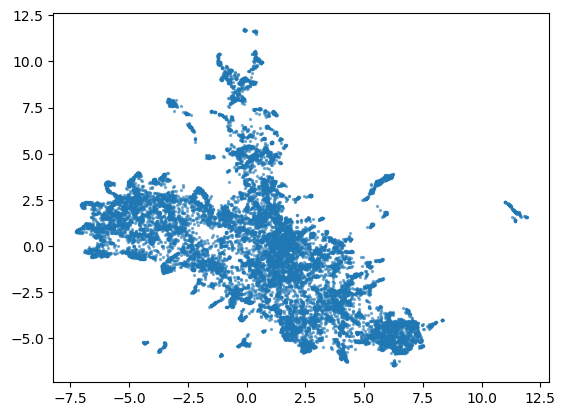

In [9]:
plt.scatter(projection[:, 0], 
            projection[:, 1], 
            # c=range(len(projection)), cmap="tab10", 
            alpha=0.5, s=2)


point = np.array([7.0, -5.0])